# Implementation of the World Bank dashboard in `altair`

Let's recreate the Tableau dashboard we built in the previous session, which is adapted from Chapter 13 of Communicating Data with Tableau by Ben Jones

<img src="./img/world_bank_dashboard.png" width=600/>

#### Load Modules

In [96]:
import pandas as pd
import altair as alt
from dfply import *
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [98]:
alt.__version__

'3.0.1'

#### Loading and joining the latitude and longitude for each country

Tableau automates a lot of annoying tasks, like geolocating countries and loading shape files.  As the world bank data didn't include the locations of each country, I had to use a geolocation service to look up the details.  You can see the code that accomplished this task in the notebook names `geolocate_countries.ipynb`.

#### A note on plotting with a large dataframe

By design, `altiar` creates a JSON specification for each graph that is stored inside the Juptyer notebook.  Consequently, when using data stored in a `pandas` dataframe, all of the data is written *explicitly* to the specification (and notebook).  This can result in VERY large notebooks, so `altair` limits the number of rows in the dataframe to 5000.  

The best workaround when working with large data is saving the data to a JSON file, then passing the path/url for the data to `altair`.  Let's see how this is done.

## Step 1 - Plot Internet Users vs. Year

We start by recreating the ling plot in the bottom left of the dashboard.  Note that this graph has the following specification.

1. **Mark:** line
2. **Encodings:**<br>
    a. **X:** Year<br>
    b. **Y:** Internet users<br>
    c. **Detail:** Country$^1$<br>
    c. **Color:** Scandinavia indicator<br>
    c. **Size:** Scandinavia indicator<br>

$^1$ We want to split up the countries, but not assign them to color, shape, etc.  In this case, we will use the **detail** encoding allows to add an extra encoding that is not tied to an aesthetic in the same way that we used detail in Tableau.

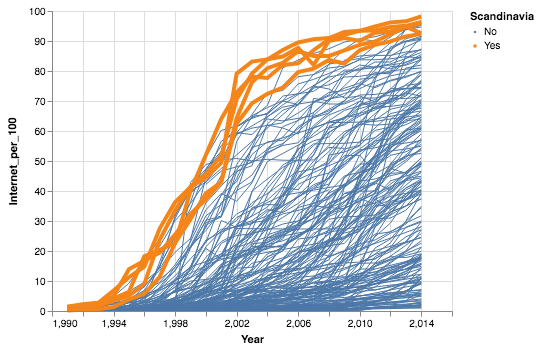

In [99]:
url = '../data/world_bank_filtered_w_lat_long.json'

internet_vs_year = (alt.Chart(url)
                    .mark_line()
                    .encode(y = 'Internet_per_100:Q',
                            x = 'Year:Q',
                            detail = 'Country:N',
                            color = 'Scandinavia:N',
                            size = 'Scandinavia:N')
                   )
internet_vs_year

#### Using sorting to bring the Scandinavian countries to the front

Note that the Scandinavian countries are drawn on top of the other countries.  This was accomplished by sorting the data, leaving the Scandinavian countries at the bottom of the dataframe/file.

### Adding Tooltips

Tooltips can be added using the `tooltip` encoding, passing this aesthetic a list of columns that should be included in the tooltip.  In this case, we want to include *Scandinavia*, *Country*, *Year*, and *Internet Users*.

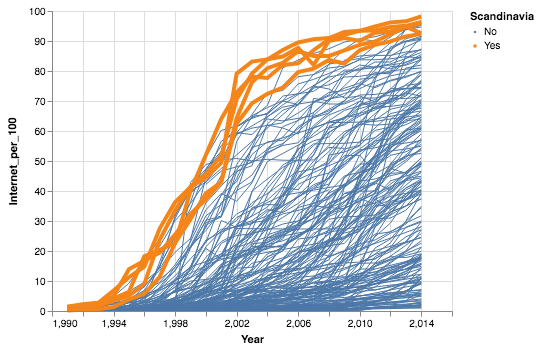

In [100]:
url = '../data/world_bank_filtered_w_lat_long.json'

internet_vs_year = (alt.Chart(url)
                    .mark_line()
                    .encode(y = 'Internet_per_100:Q',
                            x = 'Year:Q',
                            detail = 'Country:N',
                            color = 'Scandinavia:N',
                            size = 'Scandinavia:N',
                            tooltip = ['Scandinavia:N', 'Country:N', 'Internet_per_100:Q', 'Year:Q'])
                    .properties(
                        width=400,
                        height=300)
                   )
internet_vs_year

#### A note on annotations

Currently `altair` and `vega` don't support native annotations like the ones we added with Tableau.  While it [has been suggested](https://github.com/vega/vega/issues/782#issuecomment-452381813) that you can add annotations with [this D3 library](https://d3-annotation.susielu.com/), this is beyond the scope of this presentation (and my skills).  

## Step 2 - Scatterplot

Note that the scatterplot allows the user to

A. Filter based on year.
B. Select one of two variables for the size of the points.

We will start by creating a simplified version of this plot, with size determined by *Total Fertility*. Note that this plot has the the following specification:

* **Mark:** point
* **Encoding:** 
    * **X:** Internet users
    * **Y:** Life expectancy
    * **Color:** Region
    * **Size:** Total Fertilitiy or CO2 emissions
    
    
`altair` does not allow us to select a column from a pulldown, so we will focus on Total Fertility

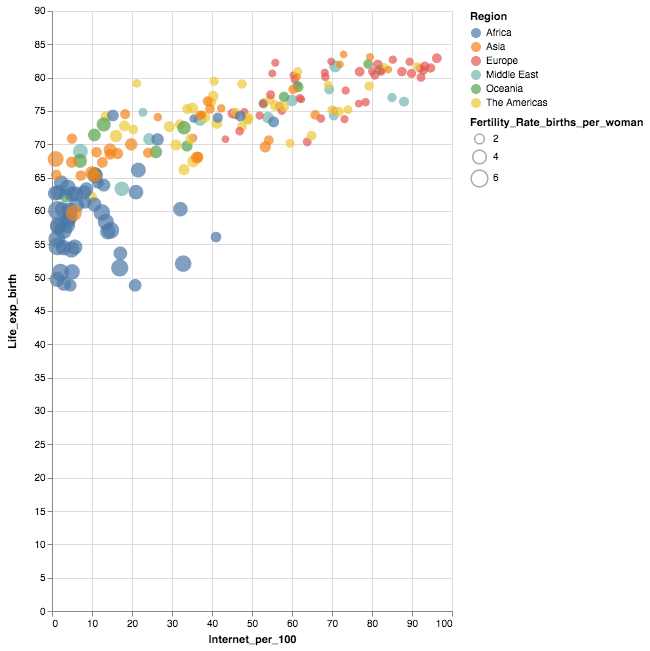

In [101]:
scatter_fill = (alt.Chart(url)
                .mark_point()
                .encode(x = 'Internet_per_100:Q',
                        y = 'Life_exp_birth:Q',
                        fill = 'Region:N',
                        size = 'Fertility_Rate_births_per_woman:Q'
                       )
                .transform_filter(
                 alt.datum.Year == 2012)
           .properties(
               width=400,
               height=600)
          )

scatter_fill

#### Adjusting properties to match the original graph

Note that the points in the original graph are filled and slightly transparent.  We can get this same effect by setting some `mark_point` properties.

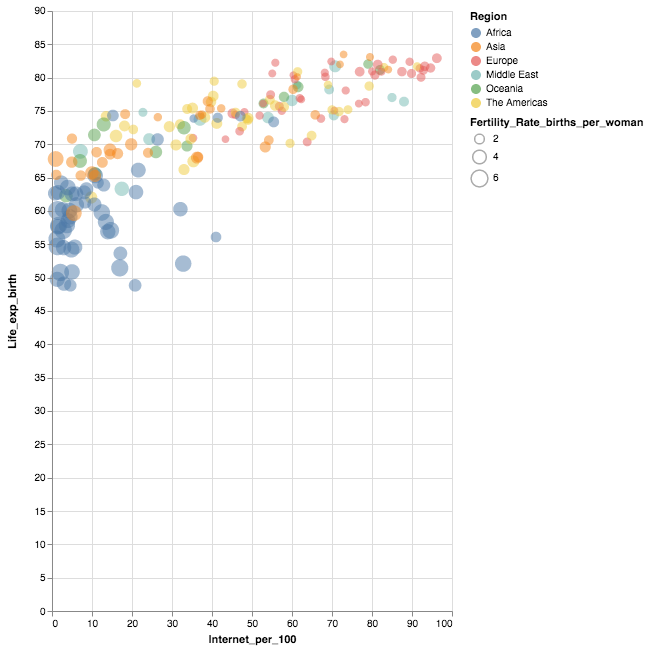

In [102]:
scatter_fill = (alt.Chart(url)
                .mark_point(filled = True,
                            fillOpacity = 0.7)
                .encode(x = 'Internet_per_100:Q',
                        y = 'Life_exp_birth:Q',
                        fill = 'Region:N',
                        size = 'Fertility_Rate_births_per_woman:Q'
                       )
                .transform_filter(
                 alt.datum.Year == 2012)
           .properties(
               width=400,
               height=600)
          )

scatter_fill

#### Adjusting the y-axis 

To adjust the y-axis to correspond to the original plot, we need to use the `alt.Y` specification and adjust the `scale` attribute.

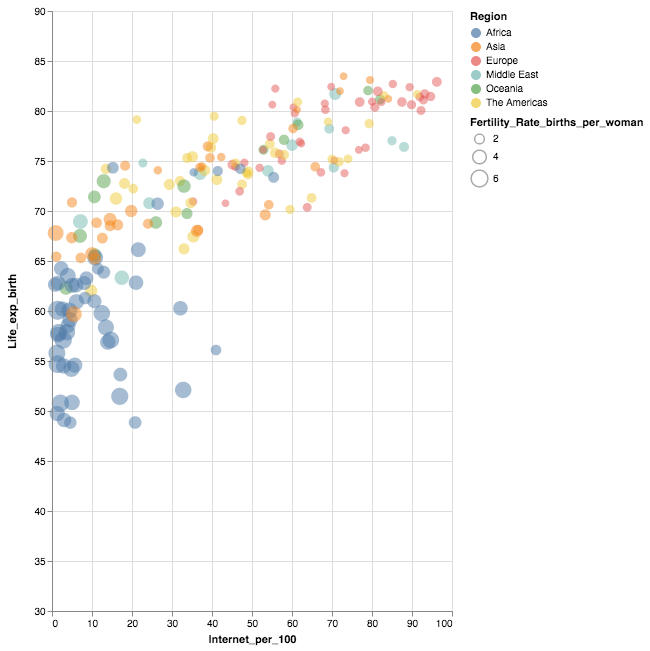

In [103]:
scatter_fill = (alt.Chart(url)
                .mark_point(filled = True,
                            fillOpacity = 0.7)
                .encode(x = 'Internet_per_100:Q',
                        y = alt.Y('Life_exp_birth:Q',
                                  scale=alt.Scale(domain=(30,90))),
                        fill = 'Region:N',
                        size = 'Fertility_Rate_births_per_woman:Q'
                       )
                .transform_filter(
                 alt.datum.Year == 2012)
           .properties(
               width=400,
               height=600)
          )

scatter_fill

#### Adjusting properties to match the original graph - Attempt 2

Note that I wasted WAY to much time figuring out how to match the original plot.  The only way I could figure out how to have the black outline on each point was to overlay two plots, one for the fill and the other for the outline.

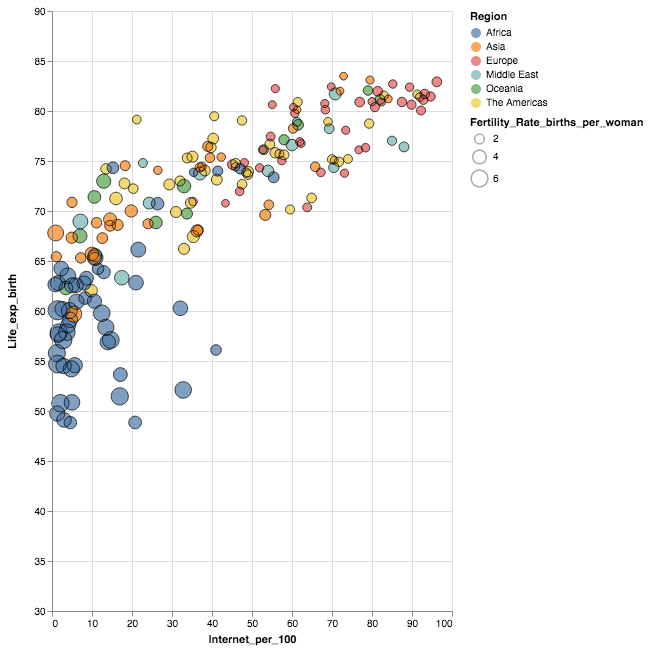

In [104]:
scatter_base =  (alt.Chart(url)
                .mark_point(filled = True,
                            color = '#000000',
                            fillOpacity = 0.7)
                .encode(x = 'Internet_per_100:Q',
                        y = alt.Y('Life_exp_birth:Q',
                                  scale=alt.Scale(domain=(30,90))),
                        size = 'Fertility_Rate_births_per_woman:Q',
                        tooltip = ['Scandinavia:N', 
                                   'Country:N', 
                                   'Internet_per_100:Q', 
                                   'Year:Q', 
                                   'CO2_metric_tons_per_capita:Q',
                                   'Fertility_Rate_births_per_woman:Q']
                       )
                .transform_filter(
                 alt.datum.Year == 2012)
           .properties(
               width=400,
               height=600)
          )
scatter_fill = (scatter_base
                .mark_point()
                .encode(fill = 'Region:N')
          )

scatter_outline = (scatter_base
                  .mark_point(color = '#000000',
                              strokeWidth = 1)
                  .encode(detail = 'Region:N')
                 )
scatter = (scatter_fill + scatter_outline)
scatter

## Step 3 - Create the US map plot

Next, we will create the plot of the United States.  Note that this plot has the the following specification:

* **Mark:** point
* **Encoding:** 
    * **Latitude:** Latitude
    * **Longitude:** Longitude
    * **Size:** Internet Users
    * **Color:** Region

### Creating the background map

We start the creation of a map in `altair` by setting up the map using `mark_geoshape` and assigning a `project`ion.  To match the original plot, we will use `'meracator'`.  Note the use of the `world_110m` data from vega to provide a base data set.

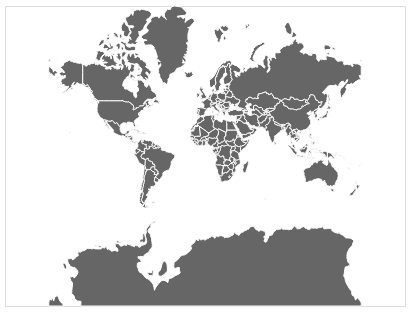

In [106]:
from vega_datasets import data

source = alt.topo_feature(data.world_110m.url, 'countries')

background = alt.Chart(source).mark_geoshape(
    fill='#666666',
    stroke='white'
).properties(
    width=400,
    height=300
).project(
    'mercator'
)
background

### Adding the circles

Next, we add the circles to the plot by making a separate `Chart` that is layered on top of the background map.  Note the two new aesthetic mappings here for `latitude` and `longitude`.

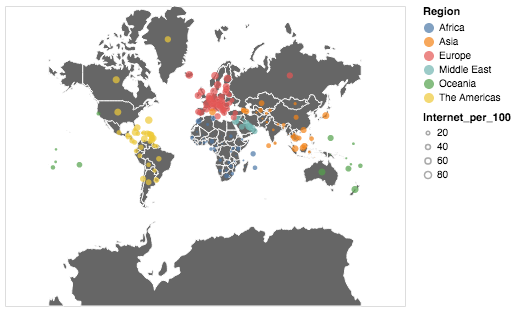

In [107]:
background = alt.Chart(source).mark_geoshape(
    fill='#666666',
    stroke='white'
).properties(
    width=400,
    height=300
).project(
    'mercator'
)


circle = (alt.Chart(url)
         .mark_point()
         .encode(latitude = 'Latitude:Q',
                 longitude = 'Longitude:Q',
                 tooltip = ['Scandinavia:N', 'Country:N', 'Internet_per_100:Q', 'Year:Q'],
                 size = alt.Size(
                     'Internet_per_100:Q',
                     scale=alt.Scale(range=(0, 60))
                 ),
                 fill = 'Region:N',
                 detail = 'Country:N')
         .transform_filter(
                alt.datum.Year == 2012)
        )

map_plot = (background + circle)
map_plot

## Putting it all together

Now we will put all three graphs together using `|` (horizontal bind) and `&` (vertical bind).

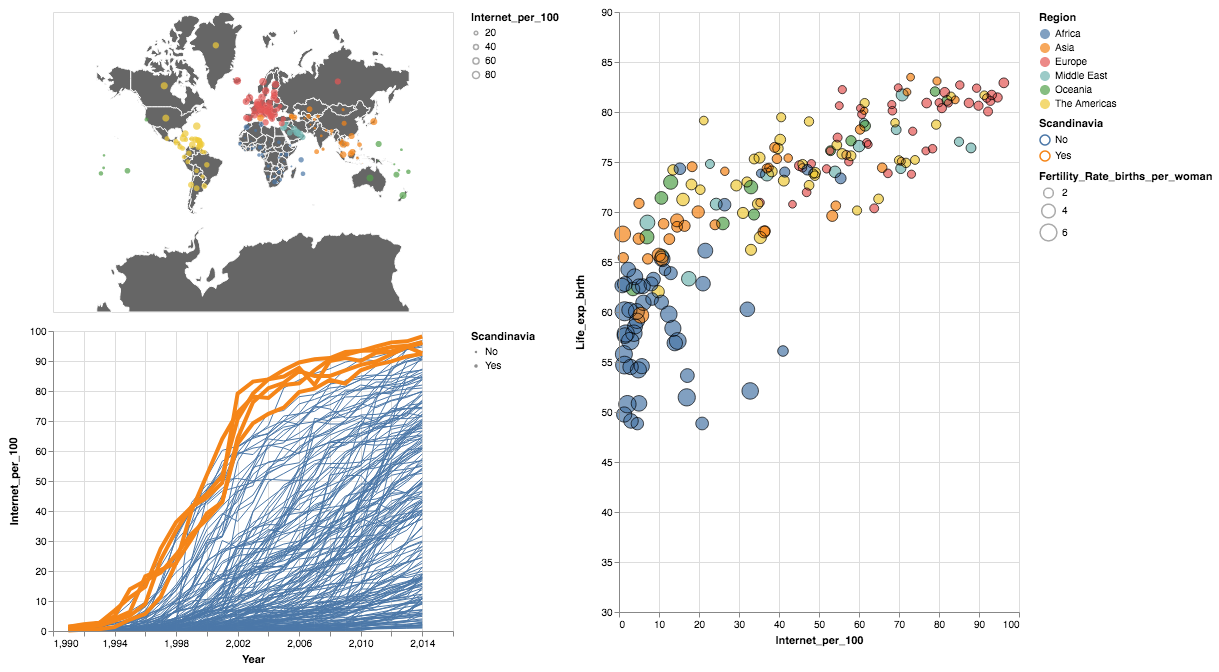

In [108]:
(map_plot & internet_vs_year) | scatter

## Bring all the code together

Before we add some interactions, it will be convenient to bring all the code together in one cell.

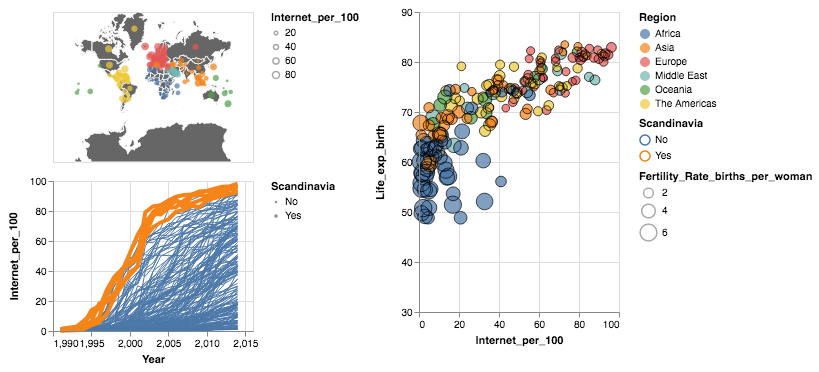

In [109]:
scatter_base =  (alt.Chart(url)
                .mark_point(filled = True,
                            color = '#000000',
                            fillOpacity = 0.7)
                .encode(x = 'Internet_per_100:Q',
                        y = alt.Y('Life_exp_birth:Q',
                                  scale=alt.Scale(domain=(30,90))),
                        size = 'Fertility_Rate_births_per_woman:Q',
                        tooltip = ['Scandinavia:N', 
                                   'Country:N', 
                                   'Internet_per_100:Q', 
                                   'Year:Q', 
                                   'CO2_metric_tons_per_capita:Q',
                                   'Fertility_Rate_births_per_woman:Q']
                       )
                .transform_filter(
                 alt.datum.Year == 2012)
           .properties(
               width=200,
               height=300)
          )
scatter_fill = (scatter_base
                .mark_point()
                .encode(fill = 'Region:N')
          )

scatter_outline = (scatter_base
                  .mark_point(color = '#000000',
                              strokeWidth = 1)
                  .encode(detail = 'Region:N')
                 )
scatter = (scatter_fill + scatter_outline)


internet_vs_year = (alt.Chart(url)
                    .mark_line()
                    .encode(y = 'Internet_per_100:Q',
                            x = 'Year:Q',
                            detail = 'Country:N',
                            color = 'Scandinavia:N',
                            size = 'Scandinavia:N',
                            tooltip = ['Scandinavia:N', 'Country:N', 'Internet_per_100:Q', 'Year:Q'])
                    .properties(
                        width=200,
                        height=150)
                   )

background = alt.Chart(source).mark_geoshape(
    fill='#666666',
    stroke='white'
).properties(
    width=200,
    height=150
).project(
    'mercator'
)

circle = (alt.Chart(url)
         .mark_point()
         .encode(latitude = 'Latitude:Q',
                 longitude = 'Longitude:Q',
                 tooltip = ['Scandinavia:N', 'Country:N', 'Internet_per_100:Q', 'Year:Q'],
                 size = alt.Size(
                     'Internet_per_100:Q',
                     scale=alt.Scale(range=(0, 60))
                 ),
                 fill = 'Region:N',
                 detail = 'Country:N')
         .transform_filter(
                alt.datum.Year == 2012)
        )

map_plot = (background + circle)


(map_plot & internet_vs_year) | scatter

## Adding a Year slider

We can added a year slider to the scatterplot as follows.  


Adding a selection slider consists of three steps.

1. Create the `binding_range` and `selection_single` objects.
2. Use `add_selection` to add the slider to one of the plots.
3. Change the `transform_filter`s to filter based on the slider.

**Note:** There is currently no way to set an initial value for the selection, but [one is on the way](https://github.com/vega/vega-lite/pull/4139).  **You will need to move the slider to add the initial filter.**

#### Applying the slider to just the scatter plot

To illustrate the process, we will start by adding the slider to just the scatterplot(s).

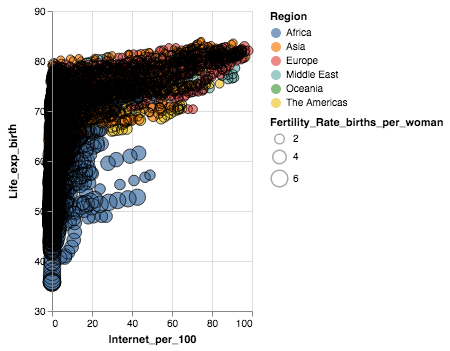

In [110]:
# A slider filter
year_slider = alt.binding_range(min=1991, max=2014, step=1)
slider_selection = alt.selection_single(bind=year_slider, 
                                        fields=['Year'],
                                        name="Year_")

scatter_base =  (alt.Chart(url)
                .mark_point(filled = True,
                            color = '#000000',
                            fillOpacity = 0.7)
                .encode(x = 'Internet_per_100:Q',
                        y = alt.Y('Life_exp_birth:Q',
                                  scale=alt.Scale(domain=(30,90))),
                        size = 'Fertility_Rate_births_per_woman:Q',
                        tooltip = ['Scandinavia:N', 
                                   'Country:N', 
                                   'Internet_per_100:Q', 
                                   'Year:Q', 
                                   'CO2_metric_tons_per_capita:Q',
                                   'Fertility_Rate_births_per_woman:Q']
                       )
           .transform_filter(
               slider_selection 
           )
           .properties(
               width=200,
               height=300)
          )
scatter_fill = (scatter_base
                .mark_point()
                .encode(fill = 'Region:N')
                .add_selection(
                    slider_selection)
          )

scatter_outline = (scatter_base
                  .mark_point(color = '#000000',
                              strokeWidth = 1)
                  .encode(detail = 'Region:N')
                 )
scatter = (scatter_fill + scatter_outline)
scatter

#### Adding the slider to the overall plot

Now we add the slider to the whole dashboard.  Note that the `transform_filter` was also added to the `map_plot`.  To illustrate the selected year on the line plot, we also added a `mark_rule` to identify the year in ques

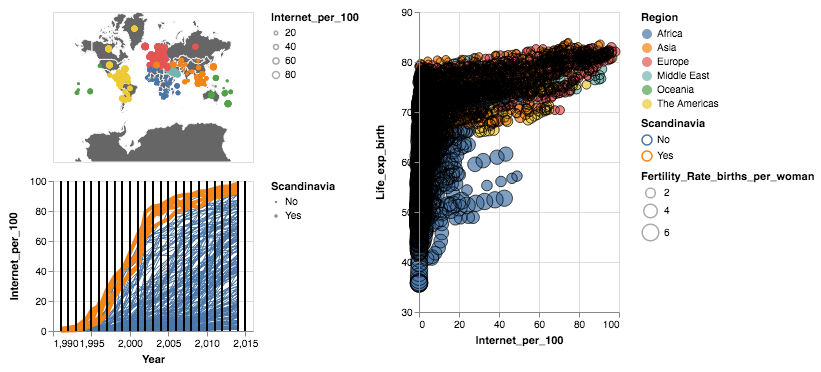

In [111]:
# A slider filter
year_slider = alt.binding_range(min=1991, max=2014, step=1)
slider_selection = alt.selection_single(bind=year_slider, 
                                        fields=['Year'],
                                        name="Year_")

scatter_base =  (alt.Chart(url)
                .mark_point(filled = True,
                            color = '#000000',
                            fillOpacity = 0.7)
                .encode(x = 'Internet_per_100:Q',
                        y = alt.Y('Life_exp_birth:Q',
                                  scale=alt.Scale(domain=(30,90))),
                        size = 'Fertility_Rate_births_per_woman:Q',
                        tooltip = ['Scandinavia:N', 
                                   'Country:N', 
                                   'Internet_per_100:Q', 
                                   'Year:Q', 
                                   'CO2_metric_tons_per_capita:Q',
                                   'Fertility_Rate_births_per_woman:Q']
                       )
           .transform_filter(
               slider_selection 
           )
           .properties(
               width=200,
               height=300)
          )
scatter_fill = (scatter_base
                .mark_point()
                .encode(fill = 'Region:N')
                .add_selection(
                    slider_selection)
          )

scatter_outline = (scatter_base
                  .mark_point(color = '#000000',
                              strokeWidth = 1)
                  .encode(detail = 'Region:N')
                 )


scatter = (scatter_fill + scatter_outline)


internet_vs_year = (alt.Chart(url)
                    .mark_line()
                    .encode(y = 'Internet_per_100:Q',
                            x = 'Year:Q',
                            detail = 'Country:N',
                            color ='Scandinavia:N',
                            size = 'Scandinavia:N',
                            tooltip = ['Scandinavia:N', 'Country:N', 'Internet_per_100:Q', 'Year:Q'])
                    .properties(
                        width=200,
                        height=150)
                   )

rule = alt.Chart(url).mark_rule(color='black').encode(
    x='Year:Q',
).transform_filter(
    slider_selection
)

line_plot = (internet_vs_year + rule)



background = alt.Chart(source).mark_geoshape(
    fill='#666666',
    stroke='white'
).properties(
    width=200,
    height=150
).project(
    'mercator'
)


circle_fill = (alt.Chart(url)
              .mark_point()
              .encode(latitude = 'Latitude:Q',
                      longitude = 'Longitude:Q',
                      size = alt.Size(
                          'Internet_per_100:Q',
                          scale=alt.Scale(range=(0, 60))
                      ),
                      fill ='Region:N',
                      detail = 'Country:N')
           .transform_filter(
               slider_selection)
             )


map_plot = (background + circle_fill)

final_plot = (map_plot & line_plot) | scatter
final_plot

#### The best part about `altair`

The best part of using `altair` is the ability to save a visualization to html and them serving it on a static server like github.  This is as easy as using the `save` method on a plot.

In [112]:
final_plot.save('world_bank_dashboard.html')